# Regressão 
Teste dois métodos de aprendizagem de máquina para identificar o que apresenta melhores resultados na previsão do volume de tráfego. Avaliem o impacto de usar validação cruzada (com 10 grupos) e split (70% para treinamento e 30% para teste). Para esse último, execute o experimento duas vezes selecionando as instâncias aleatoriamente para o treinamento e teste e avalie o impacto nos resultados.

Outras informações como dia da semana podem ser inclusas.


# Bibliotecas

In [2]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing,neighbors,model_selection, metrics,tree

# Base de Dados

In [5]:
df_base = pd.read_csv('Metro_Interstate_Traffic_Volume.csv',delimiter=',') 
df_base

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [6]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


A base de dados possui tanto dados numéricos como dados não numéricos.

# Verificando Base de Dados

## Dados Faltosos

In [7]:
df_base.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [ ]:
Não há nenhuma instância nula nos atributos.

## Dados Duplicados

In [8]:
df_base.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
48199    False
48200    False
48201    False
48202    False
48203    False
Length: 48204, dtype: bool

Não há dados duplicados!

## Identificando Outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c3be388d0>]],
      dtype=object)

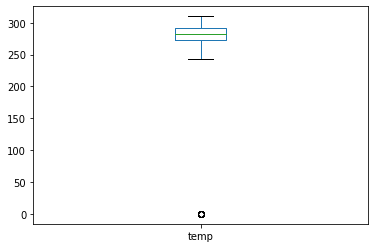

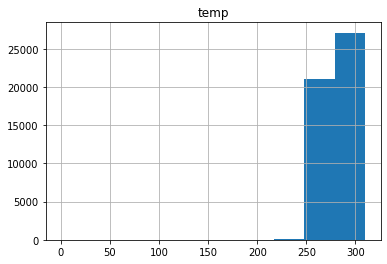

In [14]:
df_base['temp'].plot.box()
df_base.hist(column='temp')

Há alguns outliers em **temp**, provavelmente com valores próximos a _0_. O histograma mostra a distribuição dos valores do mesmo. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c3c00dd90>]],
      dtype=object)

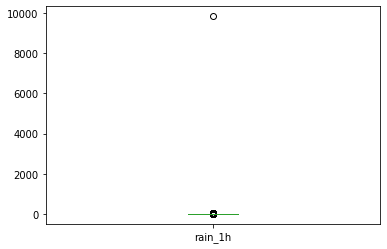

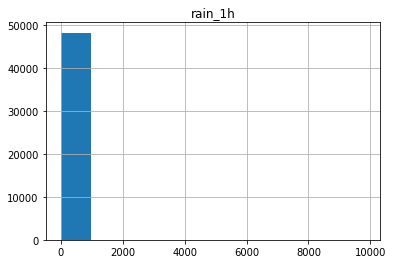

In [15]:
df_base['rain_1h'].plot.box()
df_base.hist(column='rain_1h')

 **rain_1h** possui um outlier muito discrepante. O histograma mostra a distribuição dos valores desse atributo.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c3c025bd0>]],
      dtype=object)

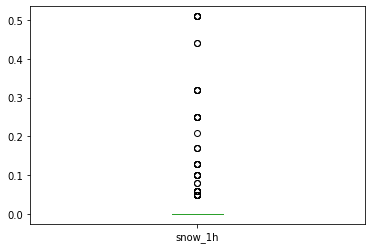

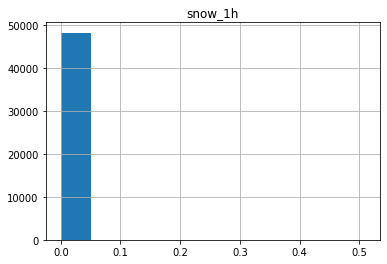

In [16]:
df_base['snow_1h'].plot.box()
df_base.hist(column='snow_1h')


Há a presença de alguns  valores fora da média, mas foram valores qque ficaram entre [0,0.5] 
Então, provavelmente, devem ser valores reais.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c3ba48110>]],
      dtype=object)

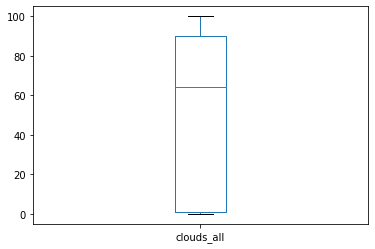

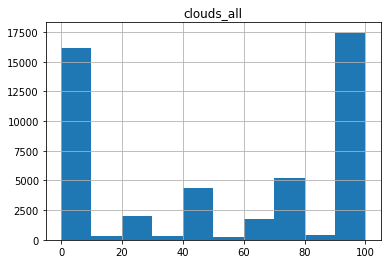

In [17]:
df_base['clouds_all'].plot.box()
df_base.hist(column='clouds_all')

In [ ]:
Não há outliers. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c3bafd750>]],
      dtype=object)

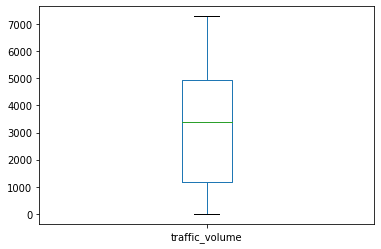

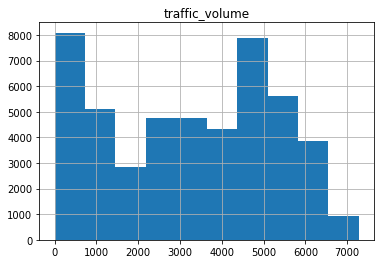

In [18]:
df_base['traffic_volume'].plot.box()
df_base.hist(column='traffic_volume')

Não há outliers em **traffic_volume**

## Dados Não Numéricos

In [20]:
print("Valores não numéricos presentes em 'holiday':",df_base['holiday'].unique(), "\n\n")
print("Valores não numéricos presentes em 'weather_main':",df_base['weather_main'].unique(), "\n\n")
print("Valores não numéricos presentes em 'weather_description':",df_base['weather_description'].unique(), "\n\n")

Valores não numéricos presentes em 'holiday': ['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day'] 


Valores não numéricos presentes em 'weather_main': ['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke'] 


Valores não numéricos presentes em 'weather_description': ['scattered clouds' 'broken clouds' 'overcast clouds' 'sky is clear'
 'few clouds' 'light rain' 'light intensity drizzle' 'mist' 'haze' 'fog'
 'proximity shower rain' 'drizzle' 'moderate rain' 'heavy intensity rain'
 'proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'heavy snow' 'heavy intensity drizzle'
 'snow' 'thunderstorm with heavy rain' 'freezing rain' 'shower snow'
 'light rain and snow' 'light intensity shower rain' 'SQUALLS'
 'thunderstorm with rain' 'proximity thunderstorm with drizzl

## Separando o Date_Time

In [28]:
df_base['date_time'] = pd.to_datetime(df_base['date_time'])
df_base['year'] = df_base['date_time'].dt.year
df_base['month'] = df_base['date_time'].dt.month
df_base['day'] = df_base['date_time'].dt.day
df_base['hour'] = df_base['date_time'].dt.hour
df_base['weekday'] = df_base['date_time'].dt.weekday
df_base


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,year,month,day,hour,weekday
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012,10,2,9,1
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012,10,2,10,1
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012,10,2,11,1
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012,10,2,12,1
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012,10,2,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543,2018,9,30,19,6
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781,2018,9,30,20,6
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159,2018,9,30,21,6
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450,2018,9,30,22,6


O **date_time** foi expandido em 5 atributos (ano, mês, dia, hora e dia da semana). ISso foi feito para que se possa avaliar, da mehor forma, como a data influencia no volume de tráfego.

Sendo assim, não se faz mais necessário manter o atributo **date_time** na base de dados. 

In [29]:
df_base = df_base.drop(columns=['date_time'])
df_base.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,year,month,day,hour,weekday
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,2012,10,2,9,1
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,2012,10,2,10,1
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,2012,10,2,11,1
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,2012,10,2,12,1
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,2012,10,2,13,1


## Histograma dos Dados Não Numéricos

None                         48143
Labor Day                        7
Christmas Day                    6
Thanksgiving Day                 6
New Years Day                    6
Martin Luther King Jr Day        6
Memorial Day                     5
State Fair                       5
Washingtons Birthday             5
Independence Day                 5
Veterans Day                     5
Columbus Day                     5
Name: holiday, dtype: int64


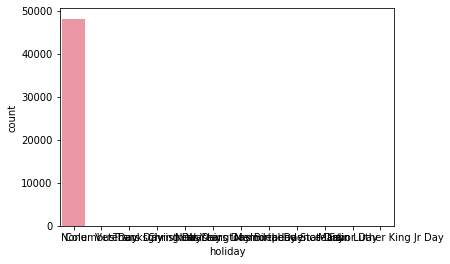

In [35]:
sns.countplot(df_base['holiday'])
qtde = df_base['holiday'].value_counts()
print(qtde)

fnvjdfkbdfv

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64


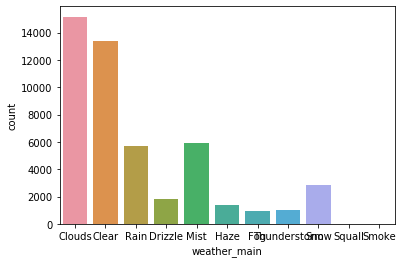

In [36]:
sns.countplot(df_base['weather_main'])
qtde = df_base['weather_main'].value_counts()
print(qtde)

hbbsdkfhvbksjdfvbkhsdfv

sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

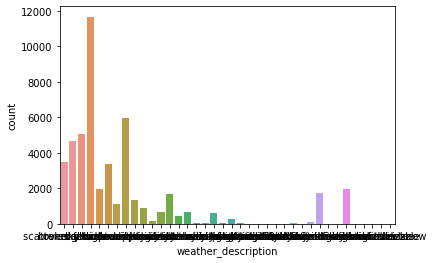

In [37]:
sns.countplot(df_base['weather_description'])
qtde = df_base['weather_description'].value_counts()
print(qtde)

dshbdhvdvjhdv

In [41]:
for weather in df_base['weather_main'].unique():
    loc = df_base.loc[df_base['weather_main']== weather]
    print("Descricoes para ", weather, ":", loc['weather_description'].unique())
    
#loc

Descricoes para  Clouds : ['scattered clouds' 'broken clouds' 'overcast clouds' 'few clouds']
Descricoes para  Clear : ['sky is clear' 'Sky is Clear']
Descricoes para  Rain : ['light rain' 'proximity shower rain' 'moderate rain'
 'heavy intensity rain' 'freezing rain' 'light intensity shower rain'
 'very heavy rain']
Descricoes para  Drizzle : ['light intensity drizzle' 'drizzle' 'heavy intensity drizzle'
 'shower drizzle']
Descricoes para  Mist : ['mist']
Descricoes para  Haze : ['haze']
Descricoes para  Fog : ['fog']
Descricoes para  Thunderstorm : ['proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'thunderstorm with heavy rain'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'thunderstorm with light drizzle'
 'thunderstorm with drizzle']
Descricoes para  Snow : ['heavy snow' 'snow' 'shower snow' 'light rain and snow' 'light snow'
 'light shower snow' 'sleet']
Descricoes para  Squall : ['SQUALLS']
Descricoes pa

# Correlação

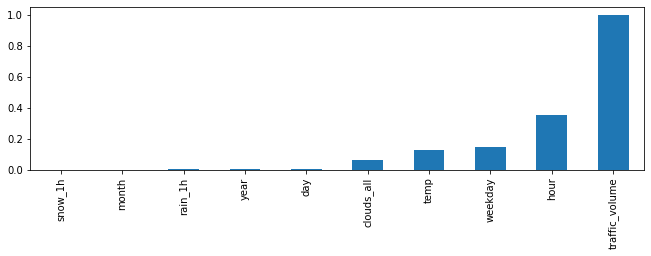

In [45]:
df_base.corr().abs()["traffic_volume"].sort_values().plot.bar(figsize=[11, 3])

In [47]:
corr = df_base.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,year,month,day,hour,weekday
temp,1,0.00906854,-0.0197552,-0.101976,0.130299,0.134945,0.223738,0.0229017,0.112089,-0.00770762
rain_1h,0.00906854,1,-8.98346e-05,0.00481813,0.0047137,0.000441939,0.00129768,-0.00229363,0.00342121,-0.00691954
snow_1h,-0.0197552,-8.98346e-05,1,0.0279309,0.000733435,-0.00351937,0.0204121,0.0157888,0.00984913,-0.0149276
clouds_all,-0.101976,0.00481813,0.0279309,1,0.0670538,-0.0728609,-0.00913346,0.0481116,0.054418,-0.0397152
traffic_volume,0.130299,0.0047137,0.000733435,0.0670538,1,0.00475323,-0.00253292,-0.00758739,0.352401,-0.149544
year,0.134945,0.000441939,-0.00351937,-0.0728609,0.00475323,1,-0.158688,0.0121924,-0.00754237,-0.012313
month,0.223738,0.00129768,0.0204121,-0.00913346,-0.00253292,-0.158688,1,0.00861361,0.00186516,0.010741
day,0.0229017,-0.00229363,0.0157888,0.0481116,-0.00758739,0.0121924,0.00861361,1,-0.00937314,0.0086776
hour,0.112089,0.00342121,0.00984913,0.054418,0.352401,-0.00754237,0.00186516,-0.00937314,1,-0.00385763
weekday,-0.00770762,-0.00691954,-0.0149276,-0.0397152,-0.149544,-0.012313,0.010741,0.0086776,-0.00385763,1
